In [3]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Sun Feb 10 2019 

CPython 3.6.8
IPython 7.2.0

numpy 1.14.6
scipy 1.1.0
sklearn 0.20.1
pandas 0.24.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.20.5-arch1-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 16
interpreter: 64bit


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

from data.data_files import CHANNEL_NAMES, DataKind, files_builder

PROJ_ROOT = os.getenv('THESIS_ROOT')
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
REC_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'recplots'))
DIRECT_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'direct'))
GAF_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'gaf'))
print(PROJ_ROOT)
print(DATA_ROOT)
print(PROCESSED_ROOT)
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
# meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '50a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES).values

/home/kovar/thesis_project/
/home/kovar/thesis_project/data
/home/kovar/thesis_project/data/processed
Opening raw data file /home/kovar/thesis_project/data/processed/50a.fif...
This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 16930 =      0.000 ...    67.720 secs
Ready.


<ipython-input-4-079058745ec5>:34: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/50a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '50a.fif'))


In [5]:
# Welford's algorithm for computing running mean and variance
def update(existingAggregate, newValues):
    (count, mean, M2) = existingAggregate
    for newValue in newValues: 
        count += 1
        delta = newValue - mean
        mean += delta / count
        delta2 = newValue - mean
        M2 += delta * delta2
        existingAggregate = (count, mean, M2)

    return (count, mean, M2)

def finalize(existingAggregate):
    (count, mean, M2) = existingAggregate
    (mean, variance) = (mean, M2/count) 
    if count < 2:
        return float('nan')
    else:
        return (mean, np.sqrt(variance))

In [6]:
# Algos
from scipy.spatial.distance import pdist, squareform
import math

def rec_plot(data, metric='chebyshev'):
    if len(data.shape) > 1:
        return squareform(pdist(data, metric=metric)).astype('float32')
    else:
        return squareform(pdist(data[:,None], metric=metric)).astype('float32')

def tabulate(x, y, f):
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

def cos_sum(x, y):
    return math.cos(x+y)

def gaf(serie):
    # Min-Max scaling
    min_ = np.amin(serie)
    max_ = np.amax(serie)
    scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

    # Floating point inaccuracy!
    scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
    scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

    # Polar encoding
    phi = np.arccos(scaled_serie)

    # GAF Computation (every term of the matrix)
    gaf = tabulate(phi, phi, cos_sum)

    return gaf

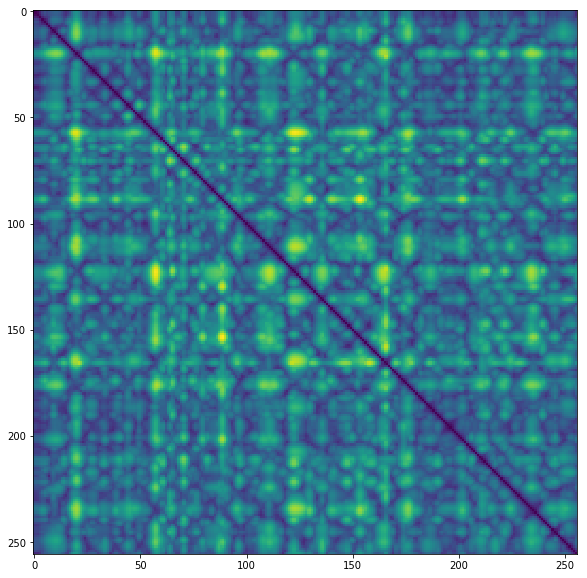

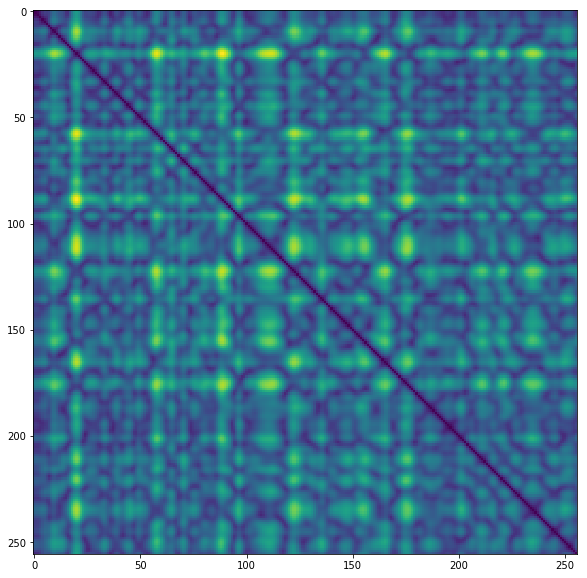

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(data):
    return cosine_similarity(data)

plt.figure(figsize=(10,10))
plt.imshow(rec_plot(data[:256,:], metric='chebyshev'))
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(rec_plot(data[:256,:], metric='euclidean'))
plt.show()

# Compute recurrence plot / GAF (multichannel distance)

In [12]:
from braindecode.datautil.signalproc import bandpass_cnt # , highpass_cnt
count, mean, M2 = 0, 0, 0
low_cut_hz = 4
high_cut_hz = None

def compute_vec(file, f, path, ww=256, maxl=np.infty, filter=True):
    global count, mean, M2
    minl = 2*ww
    start = 0
    chunk_num = 0
    while start+2*ww <= min(maxl, len(file.df['FP1'].values)):
        r = np.zeros((ww, ww))
        data = file.df.values
        if filter:
            data = bandpass_cnt(data, low_cut_hz, high_cut_hz, 250, filt_order=3, axis=1)
        # Here we may select only a subset of channels, let's try all for now
        r[:,:] = f(data[start:start+2*ww, :])[ww:2*ww, 0:ww]
        if 2*len(data) < minl + ww or r.shape[0]*r.shape[1] != ww*ww:
            print('Returning None, for file ', file.name, ', time series too short: ', len(data))
            print('Or returned wrong shape: ', r.shape, start+ww)
            return None
        count, mean, M2 = update((count, mean, M2), r.reshape(-1))
        np.save(
            os.path.join(path, ''.join((str(file.id), file.trial, '-', str(chunk_num), '.npy'))), r, fix_imports=False)
        start += ww
        chunk_num += 1
    return r

In [17]:
import logging
mne.set_log_level(logging.ERROR)
count, mean, M2 = 0, 0, 0
for i, file in enumerate(files_builder(DataKind('processed'))):
    compute_vec(file, rec_plot, os.path.join(REC_ROOT, 'vectors'))
    # compute_vec(file, cos_sim, os.path.join(GAF_ROOT, 'cos_sim'))
    print('Processed: ', i)

Processed:  0
Processed:  1
Processed:  2
Processed:  3
Processed:  4
Processed:  5
Processed:  6
Processed:  7
Processed:  8
Processed:  9
Processed:  10
Processed:  11
Processed:  12
Processed:  13
Processed:  14
Processed:  15
Processed:  16
Processed:  17
Processed:  18
Processed:  19
Processed:  20
Processed:  21
Processed:  22
Processed:  23
Processed:  24
Processed:  25
Processed:  26
Processed:  27
Processed:  28
Processed:  29
Processed:  30
Processed:  31
Processed:  32
Processed:  33
Processed:  34
Processed:  35
Processed:  36
Processed:  37
Processed:  38
Processed:  39
Processed:  40
Processed:  41
Processed:  42
Processed:  43
Processed:  44
Processed:  45
Processed:  46
Processed:  47
Processed:  48
Processed:  49
Processed:  50
Processed:  51
Processed:  52
Processed:  53
Processed:  54
Processed:  55
Processed:  56
Processed:  57
Processed:  58
Processed:  59
Processed:  60
Processed:  61
Processed:  62
Processed:  63
Processed:  64
Processed:  65
Processed:  66
Proce

In [18]:
mean, std = finalize((count, mean, M2))
path = os.path.join(REC_ROOT, 'vectors')
# path = os.path.join(GAF_ROOT, 'cos_sim')
for fn in os.listdir(path):
    filepath = os.path.join(path, fn)
    r = np.load(filepath)
    r = (r-mean) / std
    # assert (r >= -1).all() and (r <= 1).all()
    np.save(filepath, r, fix_imports=False)
print('Done')

Done


# Compute recurrence plot / GAF (separate channels)

In [6]:
def compute_sep(file, f, path, ww=256, maxl=np.infty):
    minl = ww
    start = 0
    chunk_num = 0
    while start+ww <= min(maxl, len(file.df['FP1'].values)):
        for i, channel in enumerate(CHANNEL_NAMES):
            # file_found = False
            # for fn in os.listdir(os.path.join(path, channel)):
            #     no_ext, _ = os.path.splitext(file.name)
            #     if fn.startswith(no_ext):
            #         print('File ', fn, ' already processed, for channel ', channel, ', skipping...')
            #         file_found = True
            #         break
            # if file_found: continue
            data = file.df[channel].values
            r = f(data[start:start+ww])
            if 2*len(data) < minl + ww or r.shape[0]*r.shape[1] != ww*ww:
                print('Skipping, file ', file.name, ', time series too short: ', len(data))
                print('Or returned wrong shape: ', r.shape, start+ww)
                continue
            counts[i], means[i], M2s[i] = update((counts[i], means[i], M2s[i]), r.reshape(-1))
            np.save(
                os.path.join(path, channel, ''.join((str(file.id), file.trial, '-', str(chunk_num), '.npy'))),
                r, fix_imports=False)
        start += ww
        chunk_num += 1
    return r

In [29]:
CHANNEL_NAMES = ['T6',]
counts, means, M2s = np.zeros(19), np.zeros(19), np.zeros(19)
final_means, final_stds = np.zeros(19), np.zeros(19)

for channel in CHANNEL_NAMES:
    if not os.path.exists(os.path.join(GAF_ROOT, 'sep_channels', channel)):
        os.makedirs(os.path.join(GAF_ROOT, 'sep_channels', channel))

import logging
mne.set_log_level(logging.ERROR)
for i, file in enumerate(files_builder(DataKind('processed'))):
    # compute_sep(file, rec_plot, os.path.join(REC_ROOT, 'sep_channels'))
    compute_sep(file, gaf, os.path.join(GAF_ROOT, 'sep_channels'))
    print('Processed: ', i)
    
print('Finalizing...')
for i in np.arange(len(CHANNEL_NAMES)):
    (final_means[i], final_stds[i]) = finalize((counts[i], means[i], M2s[i]))

Processed:  0
Processed:  1
Processed:  2
Processed:  3
Processed:  4
Processed:  5
Processed:  6
Processed:  7
Processed:  8
Processed:  9
Processed:  10
Processed:  11
Processed:  12
Processed:  13
Processed:  14
Processed:  15
Processed:  16
Processed:  17
Processed:  18
Processed:  19
Processed:  20
Processed:  21
Processed:  22
Processed:  23
Processed:  24
Processed:  25
Processed:  26
Processed:  27
Processed:  28
Processed:  29
Processed:  30
Processed:  31
Processed:  32
Processed:  33
Processed:  34
Processed:  35
Processed:  36
Processed:  37
Processed:  38
Processed:  39
Processed:  40
Processed:  41
Processed:  42
Processed:  43
Processed:  44
Processed:  45
Processed:  46
Processed:  47
Processed:  48
Processed:  49
Processed:  50
Processed:  51
Processed:  52
Processed:  53
Processed:  54
Processed:  55
Processed:  56
Processed:  57
Processed:  58
Processed:  59
Processed:  60
Processed:  61
Processed:  62
Processed:  63
Processed:  64
Processed:  65
Processed:  66
Proce

In [31]:
print('Saving...')
for i, channel in enumerate(CHANNEL_NAMES):
    path = os.path.join(GAF_ROOT, 'sep_channels', channel)
    for fn in os.listdir(path):
        filepath = os.path.join(path,fn)
        r = np.load(filepath)
        r[:, :] = (r[:, :]-final_means[i])/final_stds[i]
        np.save(filepath, r, fix_imports=False)

Saving...


In [113]:
print('Computing means and variances...')
path = os.path.join(DATA_ROOT, 'recplots_1')
for fn in os.listdir(path):
    r = np.load(os.path.join(path,fn))
    rs = r.reshape((-1, 19))
    for i in np.arange(r.shape[2]):
        counts[i], means[i], M2s[i] = update((counts[i], means[i], M2s[i]), rs[:, i])
        
print('Finalizing...')
for i in np.arange(len(CHANNEL_NAMES)):
    (final_means[i], final_stds[i]) = finalize((counts[i], means[i], M2s[i]))
    
print('Saving...')
for fn in os.listdir(path):
    filepath = os.path.join(path,fn)
    r = np.load(filepath)
    for i in np.arange(r.shape[2]):
        r[:, :, i] = (r[:, :, i]-final_means[i])/final_stds[i]
    np.save(filepath, r, fix_imports=False)

Computing means and variances...


FileNotFoundError: [Errno 2] No such file or directory: '/home/kovar/thesis_project/data/recplots_1/46a-48.npy'

# Directly to normalized images

In [8]:
from braindecode.datautil.signalproc import bandpass_cnt # , highpass_cnt
low_cut_hz = 4 # Suggested 0 or 4
high_cut_hz = None # 38
def compute_sep(file, path, ww=256, maxl=np.infty, rescale=True, filter=False):
    minl = ww
    start = 0
    chunk_num = 0
    N = len(file.df['FP1'].values)
    while start+ww <= min(maxl, N):
        ret = np.zeros((len(CHANNEL_NAMES), ww))
        for i, channel in enumerate(CHANNEL_NAMES):
            data = file.df[channel].values
            r = data[start:start+ww]
            if 2*len(data) < minl + ww or r.shape[0]*r.shape[0] != ww*ww:
                print('Skipping, file ', file.name, ', time series too short: ', len(data))
                print('Or returned wrong shape: ', r.shape, start+ww)
                continue
            if rescale:
                r *= 1e6
            if filter:
                r = bandpass_cnt(r, low_cut_hz, high_cut_hz, 250, filt_order=3, axis=0)
            counts[i], means[i], M2s[i] = update((counts[i], means[i], M2s[i]), r)
            ret[i, :] = r
        np.save(
            os.path.join(path, ''.join((str(file.id), file.trial, '-', str(chunk_num), '.npy'))),
            file.df.values.T[:, start:start+ww], fix_imports=False)
        start += ww
        chunk_num += 1
    return r

In [9]:
counts, means, M2s = np.zeros(19), np.zeros(19), np.zeros(19)
final_means, final_stds = np.zeros(19), np.zeros(19)

import logging
mne.set_log_level(logging.ERROR)
for i, file in enumerate(files_builder(DataKind('processed'))):
    compute_sep(file, DIRECT_ROOT)
    print('Processed: ', i)
    
print('Finalizing...')
for i in np.arange(len(CHANNEL_NAMES)):
    (final_means[i], final_stds[i]) = finalize((counts[i], means[i], M2s[i]))

Processed:  0
Processed:  1
Processed:  2
Processed:  3
Processed:  4
Processed:  5
Processed:  6
Processed:  7
Processed:  8
Processed:  9
Processed:  10
Processed:  11
Processed:  12
Processed:  13
Processed:  14
Processed:  15
Processed:  16
Processed:  17
Processed:  18
Processed:  19
Processed:  20
Processed:  21
Processed:  22
Processed:  23
Processed:  24
Processed:  25
Processed:  26
Processed:  27
Processed:  28
Processed:  29
Processed:  30
Processed:  31
Processed:  32
Processed:  33
Processed:  34
Processed:  35
Processed:  36
Processed:  37
Processed:  38
Processed:  39
Processed:  40
Processed:  41
Processed:  42
Processed:  43
Processed:  44
Processed:  45
Processed:  46
Processed:  47
Processed:  48
Processed:  49
Processed:  50
Processed:  51
Processed:  52
Processed:  53
Processed:  54
Processed:  55
Processed:  56
Processed:  57
Processed:  58
Processed:  59
Processed:  60
Processed:  61
Processed:  62
Processed:  63
Processed:  64
Processed:  65
Processed:  66
Proce

In [10]:
print('Saving...')
for fn in os.listdir(DIRECT_ROOT):
    filepath = os.path.join(DIRECT_ROOT,fn)
    r = np.load(filepath)
    assert r.shape[0] == len(CHANNEL_NAMES)
    for i in np.arange(r.shape[0]):
        r[i, :] = (r[i, :]-final_means[i])/final_stds[i]
    np.save(filepath, r, fix_imports=False)

Saving...
